In [58]:
import warnings
import requests
import pandas as pd

warnings.filterwarnings("ignore")

In [ ]:
"""
Az eredeti terv az volt, hogy a Nature-ben 2023-ban megjelent cikkeket legyűjtom, topik modellezést végzek rajtuk, és azokat a cikkeket, amik 
a leghasonlóbbak, összegzem, majd egy API-val felolvastatom.

A Scrapeléssel nem vol semmi probléma, elmentettem a cikkek címét és absztraktját egy csv-be, de a topik modellezés már nem ment olyan jól.
"""

In [59]:
# import requests
# from bs4 import BeautifulSoup
# import pandas as pd

# def scrape_nature_articles():
#     base_url = "https://www.nature.com"
#     articles_data = []
#     # Creating a dataframe with id, title and abstract columns
#     articles = pd.DataFrame(columns=['id', 'title', 'abstract'])

#     for page in range(1, 2):  # Loop through 55 pages
#         print(f"Scraping page {page}")
#         url = f"{base_url}/nature/research-articles?type=article&year=2023&page={page}"
#         response = requests.get(url)
#         soup = BeautifulSoup(response.content, 'html.parser')

#         articles = soup.find_all('article', class_='u-full-height')

#         for article in articles:
#             title_tag = article.find('a', attrs={'data-track-action': 'view article'})
#             if title_tag:
#                 title = title_tag.text.strip()
#                 article_url = base_url + title_tag.get('href')
#                 article_page = requests.get(article_url)
#                 article_soup = BeautifulSoup(article_page.content, 'html.parser')

#                 abstract_tag = article_soup.find('div', class_='c-article-section__content')
#                 abstract = abstract_tag.text.strip() if abstract_tag else "Abstract not available"

#                 articles_data.append({'title': title, 'abstract': abstract})
    
#     # Assign unique IDs to articles
#     for i, article in enumerate(articles_data):
#         article['id'] = i + 1
    
#     # Write articles to the dataframe
#     articles = pd.DataFrame(articles_data, columns=['id', 'title', 'abstract'])
                
#     return articles

# # Use the function and print the results
# articles = scrape_nature_articles()
# articles.to_csv('articles.csv', index=False)

In [ ]:
"""
Sajnos aktívan dolgoztam a topik modellezésen és nem maradt meg a kód, mert folyamatosan változtattam rajta, a végén el is kavarodtam,
de a fő probléma az volt vele, hogy nem találtam hasonlóakat. Egy idő után fel is húztam magam rajta és kitöröltem mindent, hogy majd újrakezdem.

Aztán megakadtam, mert elbizonytalanodtam a témában, aztán elkezdtem kutatni, hogy milyen egyéb módszerek vannak, amiket érdemes lenne kipróbálni
"""

In [60]:
articles = pd.read_csv('articles.csv')

In [61]:
articles['text'] = articles['title'] + ' ' + articles['abstract']
articles.drop(['title', 'abstract'], axis=1, inplace=True)

In [ ]:
"""
Aztán megtaláltam a textstat modult, ami szövegek olvasására és elemzésére szolgál. Aztán elkezdtem kísérletezni vele, hogy milyen adatokat tudok kinyerni a cikkekből.
Egész izgalmas volt - úgyhogy hozzá adtam a cikkek mellé ezeket a számokat:
"""

In [104]:
import textstat

articles['flesch_reading_ease'] = articles['text'].apply(lambda x: textstat.flesch_reading_ease(x))
articles['flesch_kincaid_grade'] = articles['text'].apply(lambda x: textstat.flesch_kincaid_grade(x))
articles['smog_index'] = articles['text'].apply(lambda x: textstat.smog_index(x))
articles['coleman_liau_index'] = articles['text'].apply(lambda x: textstat.coleman_liau_index(x))
articles['automated_readability_index'] = articles['text'].apply(lambda x: textstat.automated_readability_index(x))
articles['dale_chall_readability_score'] = articles['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
articles['difficult_words'] = articles['text'].apply(lambda x: textstat.difficult_words(x))
articles['linsear_write_formula'] = articles['text'].apply(lambda x: textstat.linsear_write_formula(x))
articles['gunning_fog'] = articles['text'].apply(lambda x: textstat.gunning_fog(x))
articles['text_standard'] = articles['text'].apply(lambda x: textstat.text_standard(x))
articles['fernandez_huerta'] = articles['text'].apply(lambda x: textstat.fernandez_huerta(x))
articles['szigriszt_pazos'] = articles['text'].apply(lambda x: textstat.szigriszt_pazos(x))
articles['gutierrez_polini'] = articles['text'].apply(lambda x: textstat.gutierrez_polini(x))
articles['crawford'] = articles['text'].apply(lambda x: textstat.crawford(x))
articles['gulpease_index'] = articles['text'].apply(lambda x: textstat.gulpease_index(x))
articles['osman'] = articles['text'].apply(lambda x: textstat.osman(x))


In [63]:
articles.head(1)

id                                               text  \
0   1  Global population profile of tropical cyclone ...   

   flesch_reading_ease_textstat  flesch_kincaid_grade_textstat  \
0                          19.1                           17.2   

   gunning_fog_textstat  smog_index_textstat  \
0                 15.33                 16.7   

   automated_readability_index_textstat  coleman_liau_index_textstat  \
0                                  20.1                         17.0   

   linsear_write_formula_textstat  dale_chall_readability_score_textstat  \
0                            19.5                                  10.22   

   readability_consensus_textstat  
0                            17.0

In [ ]:
"""
Aztán a HuggingFace-n ráakadtam pár izgalmas modellre, amivel tudtam már mit kezdeni.
Először egy modell segítségével megpróbáltam kategorizálni a cikkeket, hogy elfogultak-e vagy sem.
A modell a wikipedia corpusán lett tanítva, így alkalmasnak találtam a cikkek kategorizálására.
"""

#### HuggingFace API

In [64]:
import dotenv
import os

dotenv.load_dotenv()

hf_api_key = os.getenv('HF_API')
headers = {"Authorization": "Bearer " + hf_api_key}

In [65]:
def query(payload, api_url):
	response = requests.post(api_url, headers=headers, json=payload)
	return response.json()

#### Bias Classification
https://huggingface.co/valurank/distilroberta-bias

In [66]:
API_URL = "https://api-inference.huggingface.co/models/valurank/distilroberta-bias"

In [67]:
test_output = query({"inputs": articles.iloc[0]['text']}, API_URL)
print(test_output)

[[{'label': 'NEUTRAL', 'score': 0.5404645204544067}, {'label': 'BIASED', 'score': 0.4595354497432709}]]


In [68]:
def get_bias_and_score(row):
    output = query({
        "inputs": row['text'],
    }, API_URL)
    return pd.Series([output[0][0]['label'], output[0][0]['score']])

In [69]:
bias_labels = articles.apply(get_bias_and_score, axis=1)

In [70]:
bias_labels

0         1
0    NEUTRAL  0.540465
1    NEUTRAL  0.582590
2    NEUTRAL  0.596097
3     BIASED  0.556764
4    NEUTRAL  0.520070
..       ...       ...
575   BIASED  0.524699
576   BIASED  0.543813
577   BIASED  0.526357
578  NEUTRAL  0.561167
579  NEUTRAL  0.667451

[580 rows x 2 columns]

In [71]:
articles[['bias_label', 'bias_label_score']] = bias_labels

In [ ]:
"""
Ezturán találtam egy modellt, ami a szöveg alapján kognitív torzításokat tud mérni.
Bár szkeptikus vagyok, hogy ez valid-e, illetve hogy tudományos szövegek esetén mennyire használható, de azért kipróbáltam.
"""

##### Cognitive Bias Classification
https://huggingface.co/amedvedev/bert-tiny-cognitive-bias

In [77]:
API_URL = "https://api-inference.huggingface.co/models/amedvedev/rubert-tiny2-cognitive-bias"

In [79]:
test_output = query({"inputs": articles.iloc[0]['text']}, API_URL)
print(test_output)

[[{'label': 'LABELING', 'score': 0.3188341557979584}, {'label': 'NO DISTORTION', 'score': 0.2270776778459549}, {'label': 'OVERGENERALIZING', 'score': 0.14488016068935394}, {'label': 'REWARD FALLACY', 'score': 0.10367248952388763}, {'label': 'EMOTIONAL REASONING', 'score': 0.10029830783605576}, {'label': 'PERSONALIZATION', 'score': 0.05033237114548683}, {'label': 'CATASTROPHIZING', 'score': 0.04649767279624939}, {'label': 'SHOULD STATEMENTS', 'score': 0.008407131768763065}]]


In [80]:
def get_cognitive_bias_and_score(row):
    try:
        output = query({
            "inputs": row['text'],
        }, API_URL)
        return pd.Series([output[0][0]['label'], output[0][0]['score']])
    except KeyError:
        return pd.Series([None, None])

In [81]:
cognitive_bias_labels =  articles.apply(get_cognitive_bias_and_score, axis=1)

In [88]:
articles[['cognitive_label', 'cognitive_label_score']] = cognitive_bias_labels

In [ ]:
"""
Itt már azért menteni kellett.
"""

In [89]:
articles.to_csv('bias_articles.csv', index=False)

In [90]:
articles = pd.read_csv('bias_articles.csv')

#### Do we have any difference between the readability scores of the different bias labels?

In [ ]:
"""
Ami ezután érdekelni kezdett, hogy a modellek által kategorzált cikkeknél van-e különbség a szövegstatisztikákban.
"""

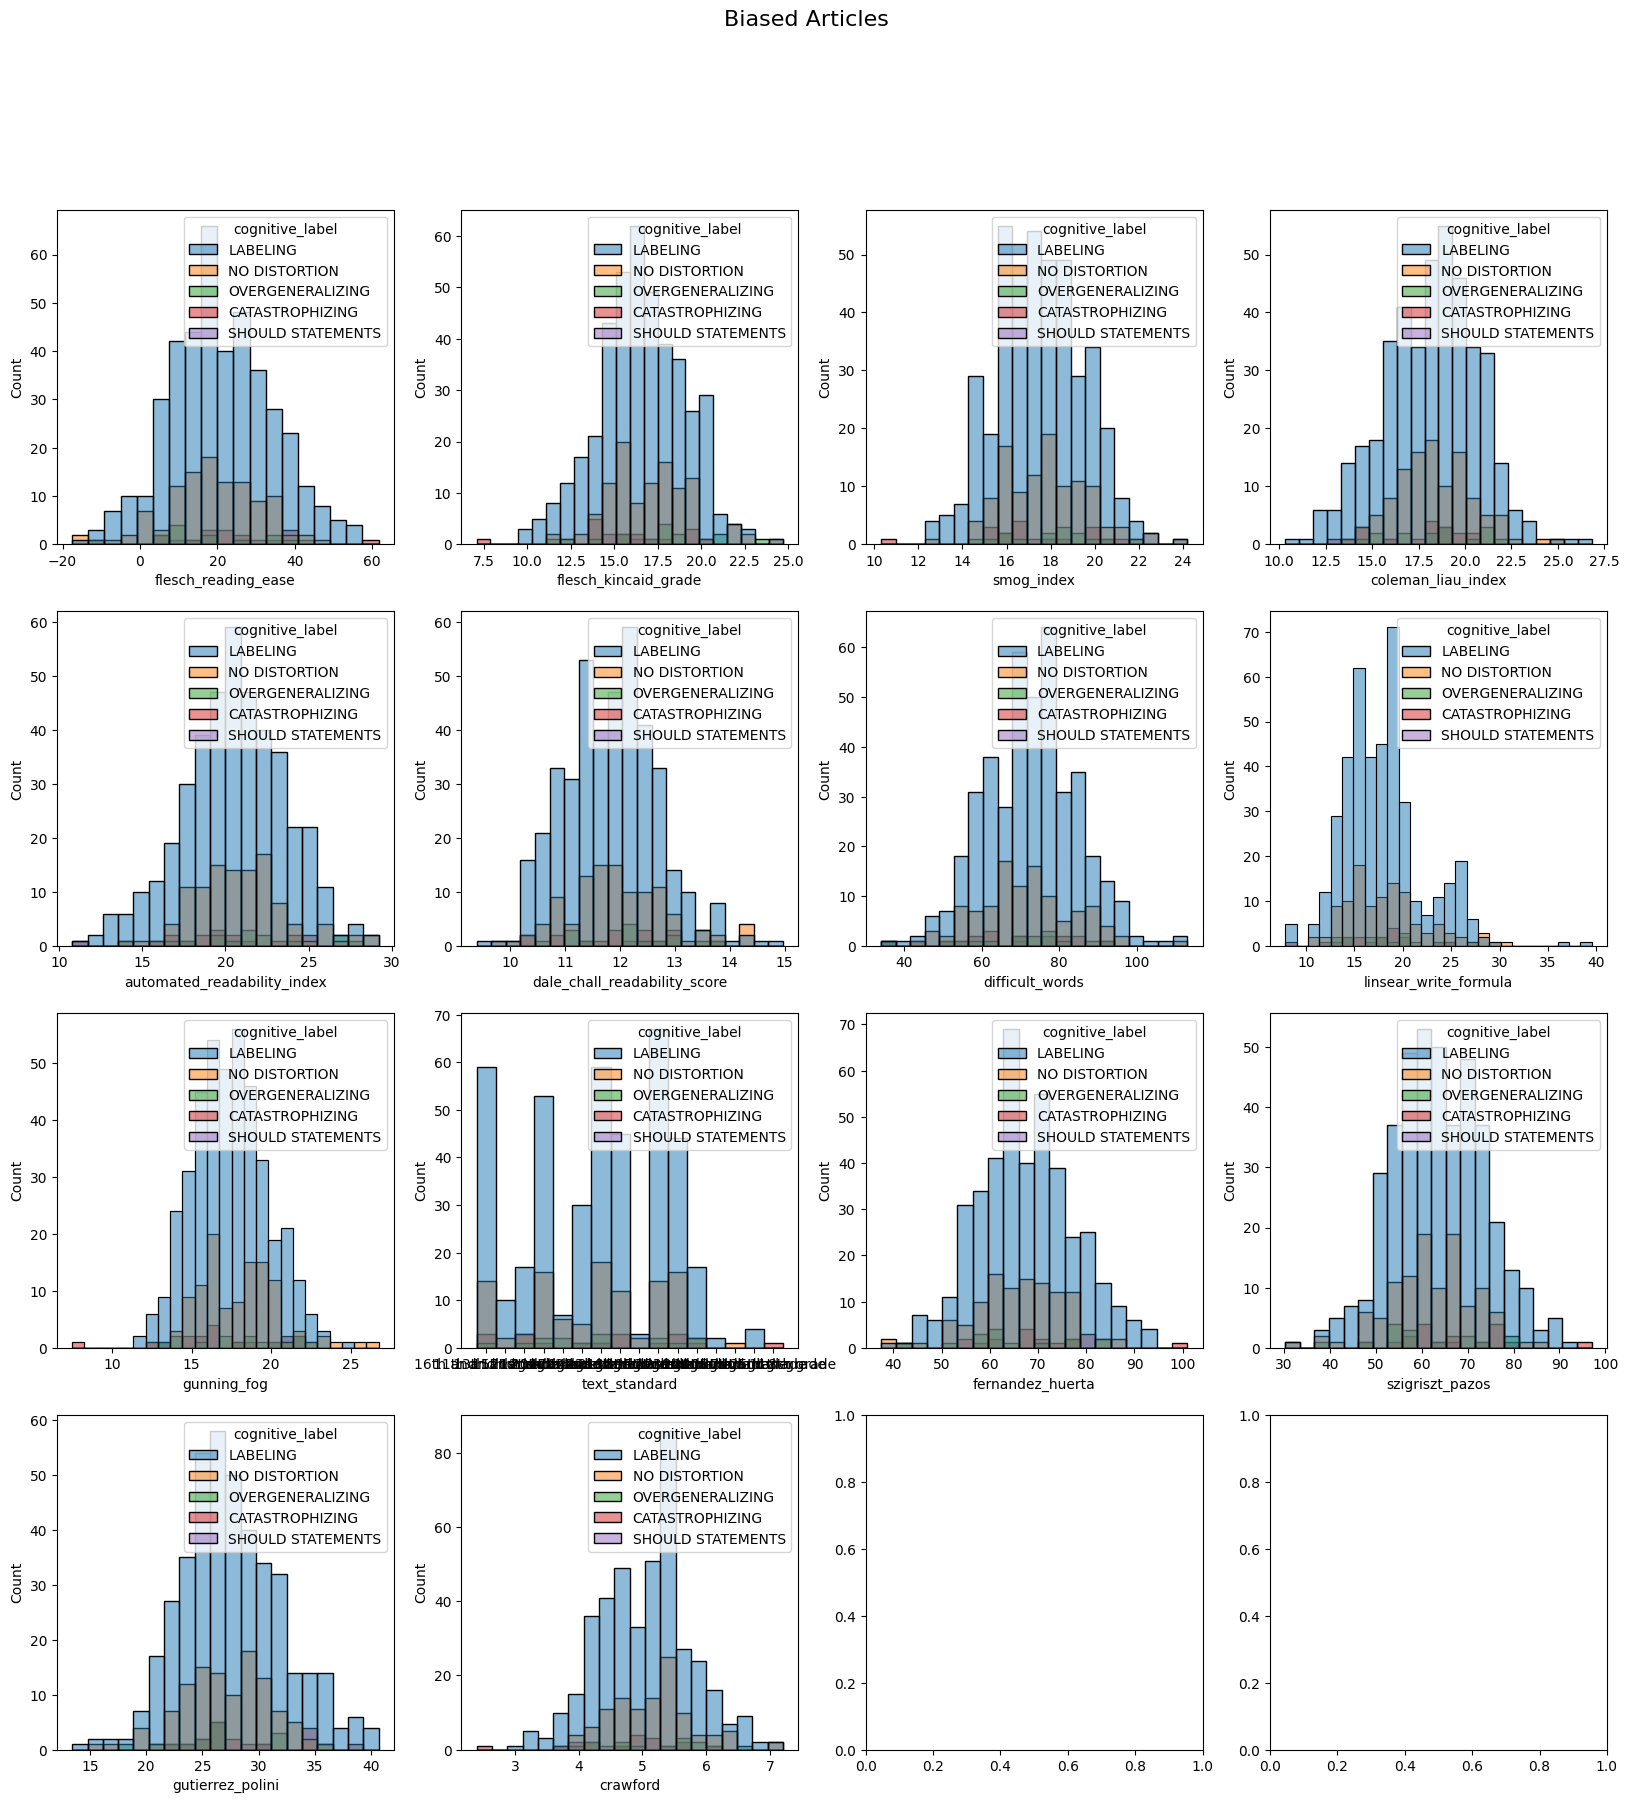

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_readability_scores(df, title):
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    fig.suptitle(title, fontsize=16)

    sns.histplot(ax=axes[0, 0], data=df, x='flesch_reading_ease', hue='cognitive_label')
    sns.histplot(ax=axes[0, 1], data=df, x='flesch_kincaid_grade', hue='cognitive_label')
    sns.histplot(ax=axes[0, 2], data=df, x='smog_index', hue='cognitive_label')
    sns.histplot(ax=axes[0, 3], data=df, x='coleman_liau_index', hue='cognitive_label')
    sns.histplot(ax=axes[1, 0], data=df, x='automated_readability_index', hue='cognitive_label')
    sns.histplot(ax=axes[1, 1], data=df, x='dale_chall_readability_score', hue='cognitive_label')
    sns.histplot(ax=axes[1, 2], data=df, x='difficult_words', hue='cognitive_label')
    sns.histplot(ax=axes[1, 3], data=df, x='linsear_write_formula', hue='cognitive_label')
    sns.histplot(ax=axes[2, 0], data=df, x='gunning_fog', hue='cognitive_label')
    sns.histplot(ax=axes[2, 1], data=df, x='text_standard', hue='cognitive_label')
    sns.histplot(ax=axes[2, 2], data=df, x='fernandez_huerta', hue='cognitive_label')
    sns.histplot(ax=axes[2, 3], data=df, x='szigriszt_pazos', hue='cognitive_label')
    sns.histplot(ax=axes[3, 0], data=df, x='gutierrez_polini', hue='cognitive_label')
    sns.histplot(ax=axes[3, 1], data=df, x='crawford', hue='cognitive_label')

plot_readability_scores(articles, 'Biased Articles')

In [ ]:
"""
Itt nem találtam semmit
"""

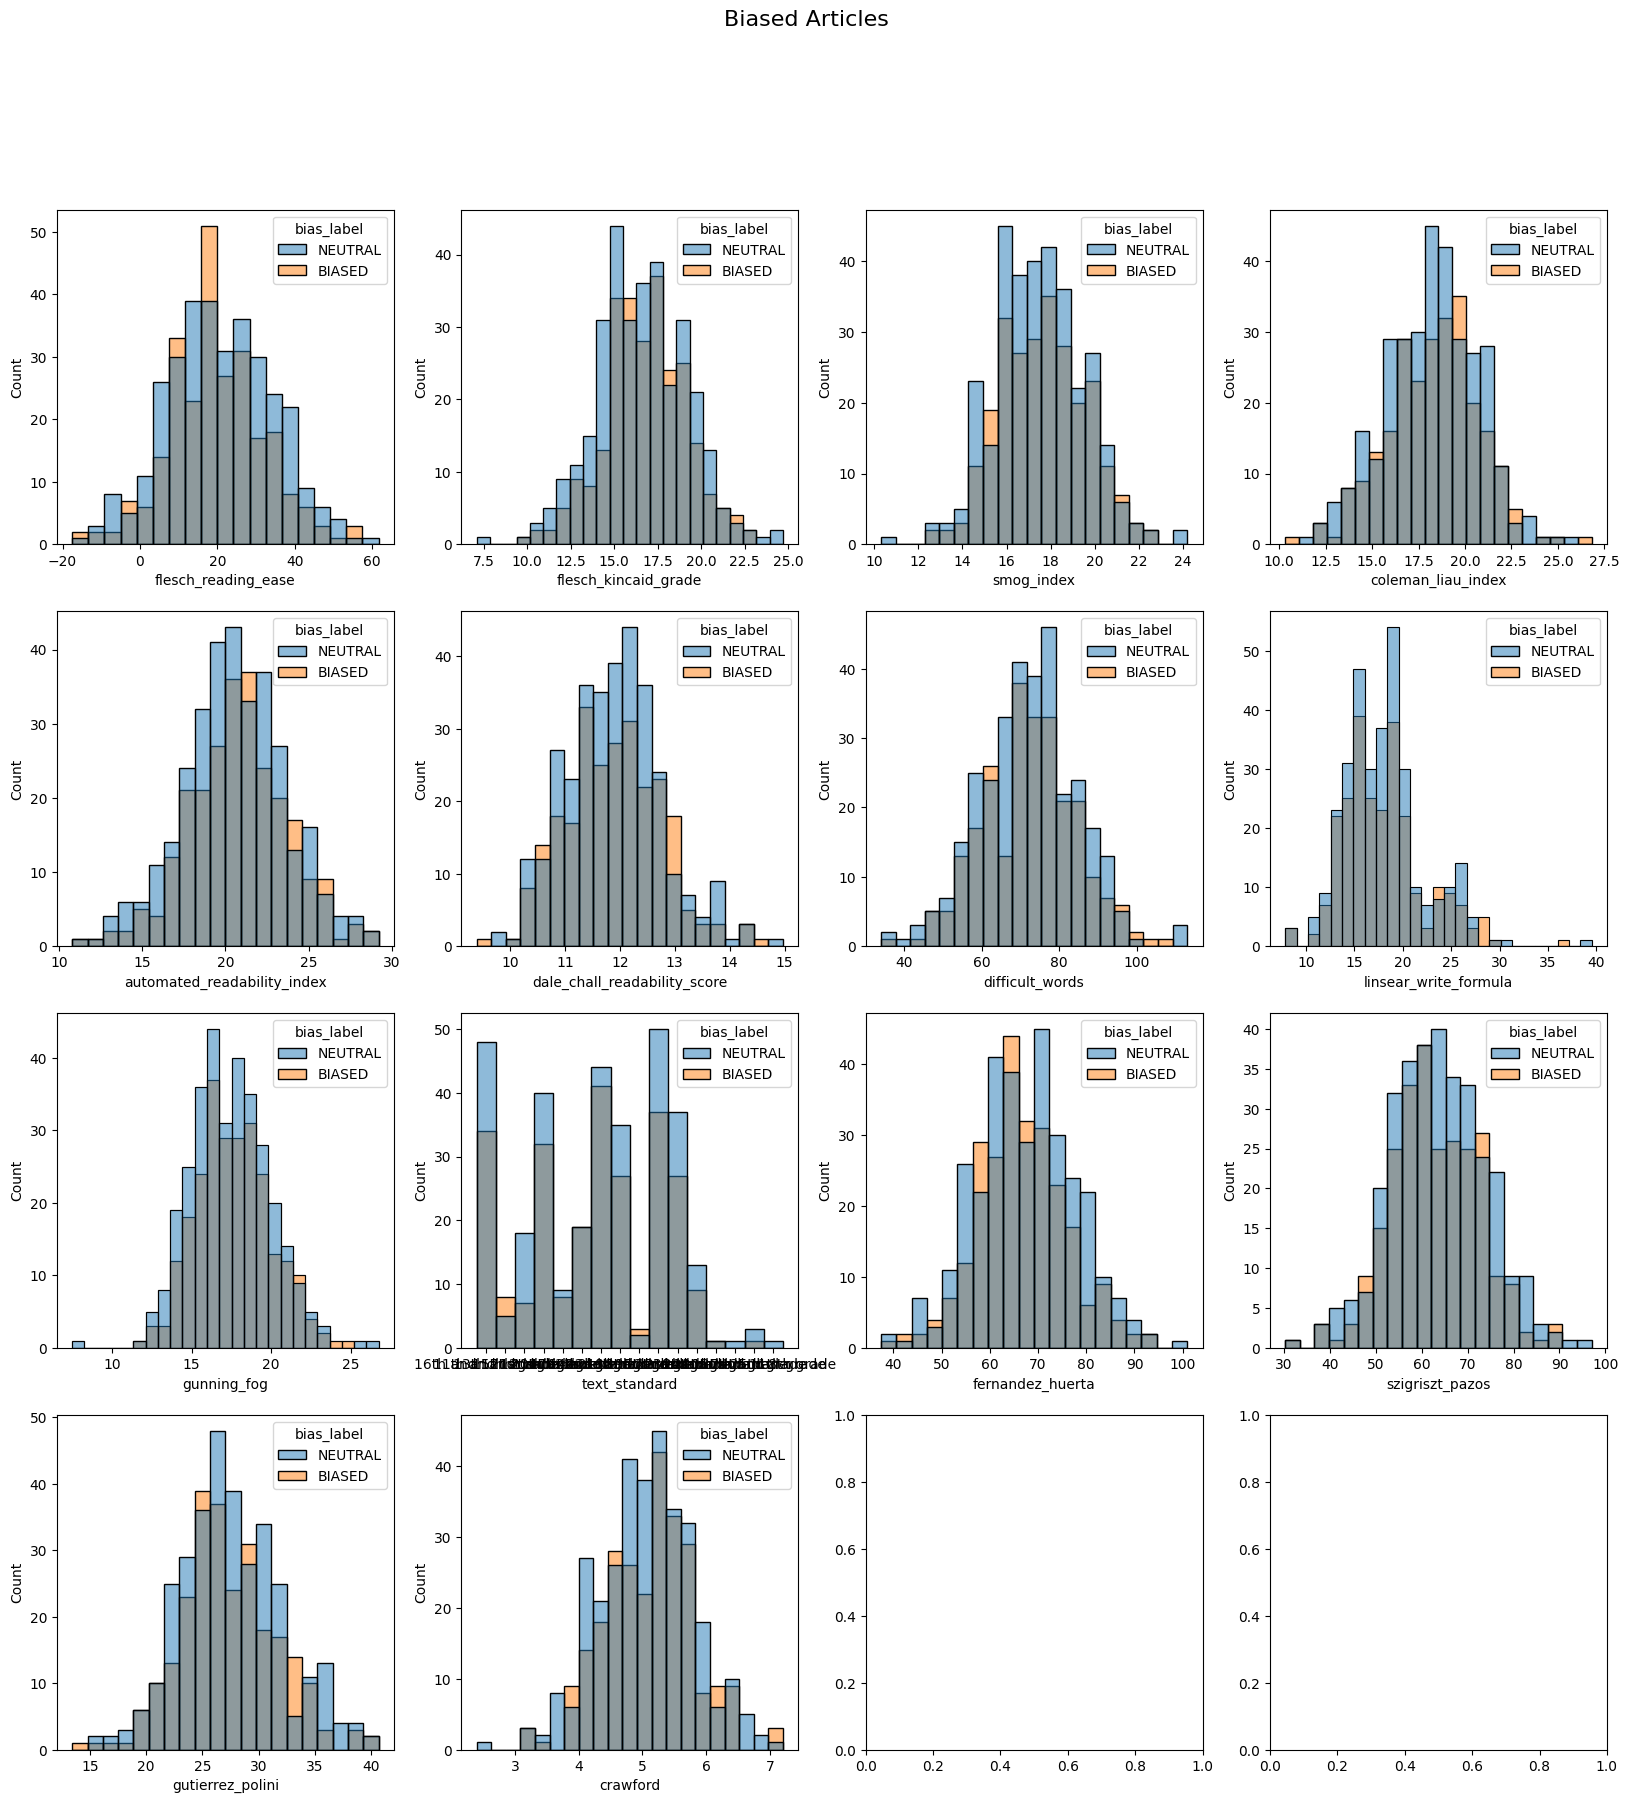

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_readability_scores(df, title):
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    fig.suptitle(title, fontsize=16)

    sns.histplot(ax=axes[0, 0], data=df, x='flesch_reading_ease', hue='bias_label')
    sns.histplot(ax=axes[0, 1], data=df, x='flesch_kincaid_grade', hue='bias_label')
    sns.histplot(ax=axes[0, 2], data=df, x='smog_index', hue='bias_label')
    sns.histplot(ax=axes[0, 3], data=df, x='coleman_liau_index', hue='bias_label')
    sns.histplot(ax=axes[1, 0], data=df, x='automated_readability_index', hue='bias_label')
    sns.histplot(ax=axes[1, 1], data=df, x='dale_chall_readability_score', hue='bias_label')
    sns.histplot(ax=axes[1, 2], data=df, x='difficult_words', hue='bias_label')
    sns.histplot(ax=axes[1, 3], data=df, x='linsear_write_formula', hue='bias_label')
    sns.histplot(ax=axes[2, 0], data=df, x='gunning_fog', hue='bias_label')
    sns.histplot(ax=axes[2, 1], data=df, x='text_standard', hue='bias_label')
    sns.histplot(ax=axes[2, 2], data=df, x='fernandez_huerta', hue='bias_label')
    sns.histplot(ax=axes[2, 3], data=df, x='szigriszt_pazos', hue='bias_label')
    sns.histplot(ax=axes[3, 0], data=df, x='gutierrez_polini', hue='bias_label')
    sns.histplot(ax=axes[3, 1], data=df, x='crawford', hue='bias_label')

plot_readability_scores(articles, 'Biased Articles')

In [ ]:
"""
És itt sem találtam semmit.
Kicsit azért reménykedtem, hogy találok valamit, szóval innentől csak saját kíváncsiságból folytattam a kutakodást.
"""

#### Which is the most biased article?

In [ ]:
"""
Kíváncsi voltam, hogy a modellek által katagorizált cikkek topikjai között van-e különbség.
Így találtam egy topik modellt a hugging Facen amit ráeresztettem a cikkekre.
"""

#### Topic modeling
https://huggingface.co/valurank/distilroberta-topic-classification

In [132]:
API_URL = "https://api-inference.huggingface.co/models/valurank/distilroberta-topic-classification"

In [133]:
test_output = query({"inputs": articles.iloc[0]['text']}, API_URL)
print(test_output)

[[{'label': 'Environmental Science', 'score': 0.6971019506454468}, {'label': 'Climate Change', 'score': 0.041120387613773346}, {'label': 'Biology', 'score': 0.021911947056651115}, {'label': 'Chemistry and Material Sciences', 'score': 0.009960870258510113}, {'label': 'Emerging Technologies', 'score': 0.006974842865020037}, {'label': 'Global Organizations', 'score': 0.004919785540550947}, {'label': 'Global Health', 'score': 0.00413797702640295}, {'label': 'Interest Rates', 'score': 0.003964341711252928}, {'label': 'Discover', 'score': 0.00393505347892642}, {'label': 'Banking & Finance', 'score': 0.0037826462648808956}, {'label': 'US Involvement in Foreign Conflicts', 'score': 0.0037528942339122295}, {'label': 'Operating Systems', 'score': 0.003403344191610813}, {'label': 'Disease Research', 'score': 0.003363575553521514}, {'label': 'Longevity', 'score': 0.0033377213403582573}, {'label': 'Physics', 'score': 0.0031835930421948433}, {'label': 'Australia Business & Economics', 'score': 0.003

In [134]:
def get_topic(row):
    try:
        output = query({
            "inputs": row['text'],
        }, API_URL)
        return pd.Series([output[0][0]['label'], output[0][0]['score'], output[0][1]['label'], output[0][1]['score']])
    except KeyError:
        return pd.Series([None, None])

In [136]:
topic_labels =  articles.apply(get_topic, axis=1)

In [137]:
articles[['primary_topic_label', 'primary_topic_score', 'secondary_topic_label', 'secondary_topic_score']] = topic_labels

In [150]:
filtered_articles = articles[(articles['bias_label'] == 'BIASED') & (articles['cognitive_label'] != 'NO DISTORTION')]
filtered_articles['bias_index'] = filtered_articles['bias_label_score'] * filtered_articles['cognitice_label_score']
top25_biased = filtered_articles[['text', 'bias_label', 'bias_label_score', 'cognitive_label', 'cognitice_label_score', 'bias_index', 'primary_topic_label']].sort_values(by='bias_index', ascending=False).head(50)

In [139]:
# articles.to_csv('topc_bias_articles.csv', index=False)

In [ ]:
"""
Nem meglepő, hogy a Nature-ben megjelent cikkek Biológia és Fizika témájúak.
"""

In [151]:
top25_biased['primary_topic_label'].value_counts()

primary_topic_label
Biology                            17
Physics                            12
Environmental Science               4
Disease Research                    3
Chemistry and Material Sciences     2
Vaccine Development                 2
Emerging Technologies               2
Mental Health Treatments            1
Medical Innovations                 1
Europe Politics                     1
Cosmology & The Universe            1
Social Media                        1
Epidemics & Outbreaks               1
Climate Change                      1
Name: count, dtype: int64

In [ ]:
"""
Itt kíváncsi voltam arra, hogy van-e nagy különbség topikok között torzított és nem torzított cikkek száma között.
"""

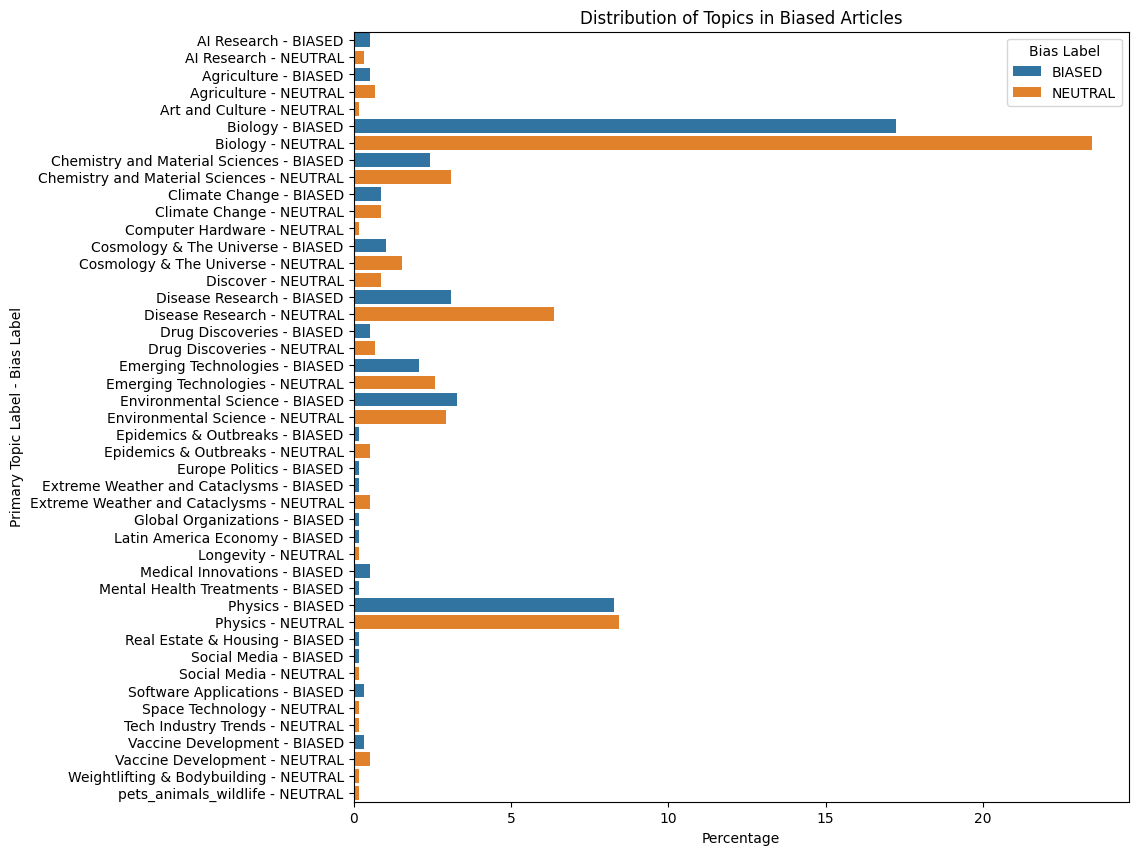

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

total_articles = articles.shape[0]

# Group by primary_topic_label and bias_label, and calculate the percentage counts
percentage_counts = articles.groupby(['primary_topic_label', 'bias_label']).size() / total_articles * 100


fig, ax = plt.subplots(figsize=(10, 10))

# Convert MultiIndex to a list of strings
index_labels = [" - ".join(idx) for idx in percentage_counts.index.tolist()]

sns.barplot(ax=ax, x=percentage_counts.values, y=index_labels, hue=percentage_counts.index.get_level_values('bias_label'))

plt.xlabel('Percentage')
plt.ylabel('Primary Topic Label - Bias Label')
plt.title('Distribution of Topics in Biased Articles')

plt.legend(title='Bias Label')

plt.show()


In [ ]:
"""
Érdekesnek találtam, hogy az Envirnomental Science esetén több a torzított cikk, mint a nem torzított.
"""

In [ ]:
"""
Aztán nyilván szerettem volna azért valamennyir megvalósítani az eredeti projektből, így találtam egy API-t, ami felolvassa a szöveget.
"""

#### Converting articles to audio
https://huggingface.co/facebook/mms-tts-eng

In [168]:
API_URL = "https://api-inference.huggingface.co/models/facebook/mms-tts-eng"

In [172]:
def audio_query(payload, api_url):
	response = requests.post(api_url, headers=headers, json=payload)
	return response.content

In [173]:
test_audio = audio_query({"inputs": articles.iloc[0]['text']}, API_URL)

In [ ]:
"""
Szuper izgalmas.
"""

In [174]:
from IPython.display import Audio
Audio(test_audio)

In [ ]:
"""
Mivel eddig csak API-kat használtam, kíváncsi voltam arra is, hogy milyen natívan használni a transformers könyvtárral de azt a gépem már nem bírta el, így a Google Colabot használtam.
A diosi_makos_tamas_text_to_video.ipynb file-ban található a kód, amivel csináltam egy videót az egyik cikk témájáról: tropical cyclone exposure

Az output file-t elmentettem tmpx5x4i7bq.mp4 néven
"""

In [ ]:
"""
Nagy learning volt, hogy a HuggingFace API ilyen szépen és egyszerűen működik, szóval örültem ennek a projektmunkának!

Köszönjük a félévet!
"""